In [1]:
!nvidia-smi

Sat Jul 15 20:00:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.2 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=3f5d4bab1974c4012874ba3f0332ad40e38bab268162bcaf187b94796b7f4649
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found

In [3]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MY API")
project = rf.workspace("flowersdetection").project("flowers_segmentation")
dataset = project.version(12).download("coco-segmentation")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to flowers_segmentation-12 in coco-segmentation:: 100%|██████████| 7345/7345 [00:02<00:00, 3345.30it/s]


In [5]:
register_coco_instances("asl_poly_train", {}, f"./flowers_segmentation-12/train/_annotations.coco.json", f"./flowers_segmentation-12/train/")
register_coco_instances("asl_poly_valid", {}, f"./flowers_segmentation-12/valid/_annotations.coco.json", f"./flowers_segmentation-12/valid/")


WARNING [07/15 20:08:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/15 20:08:10 d2.data.datasets.coco]: Loaded 6316 images in COCO format from ./flowers_segmentation-12/train/_annotations.coco.json


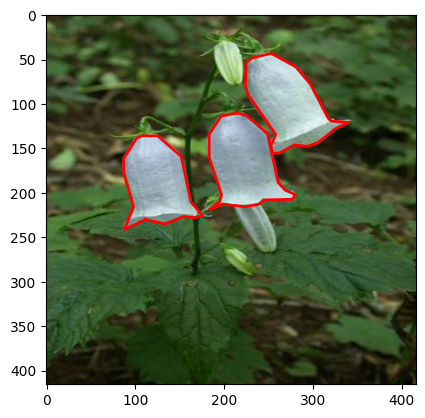

In [7]:
dataset_train = DatasetCatalog.get("asl_poly_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("asl_poly_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("asl_poly_valid",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2

In [10]:
import os
PATH = os.path.join("model_final.pth")
#from google.colab import drive
#drive.mount('/content/drive')
PATH2 = os.path.join('/content/drive/MyDrive', "model_final.pth")
import shutil

# Define the source file path
#source_file_path = '/content/drive/MyDrive/Path/To/Your/File.ext'

# Define the destination file path
#destination_file_path = '/content/drive/MyDrive/Path/To/Your/Copy/File.ext'

# Copy the file
shutil.copy(PATH2,PATH)

'model_final.pth'

In [11]:

cfg.MODEL.WEIGHTS = os.path.join("model_final.pth")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000 #We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 107 # 106 letters plus one super class
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training

PATIENCE = 500 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [12]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break

do_test(cfg, model)

[07/15 20:14:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from model_final.pth ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [07/15 20:14:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/15 20:14:30 d2.data.datasets.coco]: Loaded 6316 images in COCO format from ./flowers_segmentation-12/train/_annotations.coco.json
[07/15 20:14:30 d2.data.build]: Removed 5 images with no usable annotations. 6311 images left.
[07/15 20:14:30 d2.data.build]: Distribution of instances among all 107 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    flowers    | 0            |    Acaulis    | 87           | Alstroemeria  | 94           |
|   Artichoke   | 77           |    Bommaji    | 100          |     Calla     | 57           |
|   Carnation   | 61           |  Chamnahree   | 31           |    Cosmos     | 32           |
|    Curcuma    | 32           |   Dalnancho   | 49           |   Dandelio

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


[07/15 20:14:40 d2.utils.events]:  iter: 19  total_loss: 6.921  loss_cls: 6.013  loss_box_reg: 0.1817  loss_mask: 0.7007  loss_rpn_cls: 0.001493  loss_rpn_loc: 0.003906     lr: 4.9953e-06  max_mem: 1892M
[07/15 20:14:52 d2.utils.events]:  eta: 1:32:31  iter: 39  total_loss: 1.73  loss_cls: 0.862  loss_box_reg: 0.1657  loss_mask: 0.6795  loss_rpn_cls: 0.006081  loss_rpn_loc: 0.005397     lr: 9.9902e-06  max_mem: 1892M
[07/15 20:14:59 d2.utils.events]:  eta: 1:00:18  iter: 59  total_loss: 1.234  loss_cls: 0.3657  loss_box_reg: 0.2153  loss_mask: 0.6559  loss_rpn_cls: 0.002389  loss_rpn_loc: 0.004983     lr: 1.4985e-05  max_mem: 1892M
[07/15 20:15:06 d2.utils.events]:  eta: 1:00:30  iter: 79  total_loss: 1.332  loss_cls: 0.4136  loss_box_reg: 0.2455  loss_mask: 0.64  loss_rpn_cls: 0.001268  loss_rpn_loc: 0.006463     lr: 1.998e-05  max_mem: 1892M
[07/15 20:15:14 d2.utils.events]:  eta: 1:02:37  iter: 99  total_loss: 1.037  loss_cls: 0.271  loss_box_reg: 0.1752  loss_mask: 0.561  loss_rpn_

OrderedDict([('bbox',
              {'AP': 23.13507220982509,
               'AP50': 33.89781069218343,
               'AP75': 27.390310343721087,
               'APs': 7.608910891089109,
               'APm': 12.767117554495453,
               'APl': 24.592530044362242,
               'AP-flowers': nan,
               'AP-Acaulis': 4.282178217821783,
               'AP-Alstroemeria': 13.029874416013032,
               'AP-Artichoke': 0.0,
               'AP-Bommaji': 29.97931936050748,
               'AP-Calla': 51.86468646864686,
               'AP-Carnation': 4.176417641764177,
               'AP-Chamnahree': 0.0,
               'AP-Cosmos': 26.930693069306933,
               'AP-Curcuma': 0.0,
               'AP-Dalnancho': 0.0,
               'AP-Dandelion': 47.36627868472467,
               'AP-Dongja': 15.445544554455445,
               'AP-Doraji': 0.8048310637188227,
               'AP-Echinacea': 54.524057668924776,
               'AP-Englishdaisy': 41.668818823297805,
      

In [13]:
PATH = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
torch.save(model.state_dict(), PATH)

In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("asl_poly_valid")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = Image.fromarray(out.get_image()[:, :, ::-1])
    im

[07/15 20:45:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [07/15 20:45:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/15 20:45:13 d2.data.datasets.coco]: Loaded 1023 images in COCO format from ./flowers_segmentation-12/valid/_annotations.coco.json
{'instances': Instances(num_instances=1, image_height=416, image_width=416, fields=[pred_boxes: Boxes(tensor([[163.2784,   0.6691, 407.9908, 149.2454]], device='cuda:0')), scores: tensor([0.2353], device='cuda:0'), pred_classes: tensor([18], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, Fals

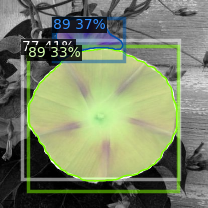

In [21]:
im

In [23]:
import os
PATH = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
from google.colab import drive
drive.mount('/content/drive')
PATH2 = os.path.join('/content/drive/MyDrive', "model_final_v12.pth")
import shutil

# Define the source file path
#source_file_path = '/content/drive/MyDrive/Path/To/Your/File.ext'

# Define the destination file path
#destination_file_path = '/content/drive/MyDrive/Path/To/Your/Copy/File.ext'

# Copy the file
shutil.copy(PATH,PATH2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/model_final_v12.pth'